AlexNet。它是第一个在大规模视觉竞赛中击败传统计算机视觉模型的大型神经网络；

使用重复块的网络（VGG）。它利用许多重复的神经网络块；

网络中的网络（NiN）。它重复使用由卷积层和
卷积层（用来代替全连接层）来构建深层网络;

含并行连结的网络（GoogLeNet）。它使用并行连结的网络，通过不同窗口大小的卷积层和最大汇聚层来并行抽取信息；

残差网络（ResNet）。它通过残差块构建跨层的数据通道，是计算机视觉中最流行的体系架构；

稠密连接网络（DenseNet）。它的计算成本很高，但给我们带来了更好的效果。

# 深度卷积神经网络（AlexNet）  
2012年，AlexNet横空出世。它首次证明了学习到的特征可以超越手工设计的特征

![20230620142833](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230620142833.png)

## 模型设计
激活函数采用更简单的RELu，并通过dropout控制全连接层的模型复杂度  
同时在训练时增加大量的图像增强数据，使得模型更健壮

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    # 采用二维卷积，（输入通道数，输出通道数，卷积核大小，步幅，填充）
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [3]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [4]:
# 读取数据集，并将28*28的图像增加到224*224
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.331, train acc 0.879, test acc 0.879
647.3 examples/sec on cuda:0


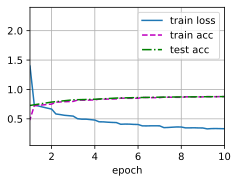

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结
AlexNet的架构与LeNet相似，但使用了更多的卷积层和更多的参数来拟合大规模的ImageNet数据集。

今天，AlexNet已经被更有效的架构所超越，但它是从浅层网络到深层网络的关键一步。

尽管AlexNet的代码只比LeNet多出几行，但学术界花了很多年才接受深度学习这一概念，并应用其出色的实验结果。这也是由于缺乏有效的计算工具。

Dropout、ReLU和预处理是提升计算机视觉任务性能的其他关键步骤。

# 使用块的网络（VGG）

## VGG块
在最初的VGG论文中 ，作者使用了带有卷积核、填充为1（保持高度和宽度）的卷积层，和带有
汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层。

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

# 该函数有三个参数，分别对应于卷积层的数量num_convs、输入通道的数量in_channels 和输出通道的数量out_channels.
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

![20230620151956](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230620151956.png)

VGG神经网络连接 图7.2.1的几个VGG块（在vgg_block函数中定义）。其中有超参数变量conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11

In [7]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [8]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


KeyboardInterrupt: 

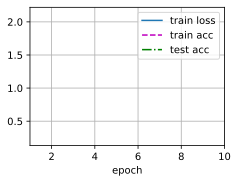

In [9]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结
VGG-11使用可复用的卷积块构造网络。不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义。

块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。

在VGG论文中，Simonyan和Ziserman尝试了各种架构。特别是他们发现深层且窄的卷积（即
）比较浅层且宽的卷积更有效

# 网络中的网络（NiN）
然而，如果使用了全连接层，可能会完全放弃表征的空间结构。 网络中的网络（NiN）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机

![20230620164932](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230620164932.png)

## 小结
1.NiN使用由一个卷积层和多个卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。

2.NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。

3.移除全连接层可减少过拟合，同时显著减少NiN的参数。

4.NiN的设计影响了许多后续卷积神经网络的设计。

# 含并行连结的网络（GoogLeNet）
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。

在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）  
![20230621111334](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230621111334.png)  

Inception块由四条并行路径组成。 前三条路径使用窗口大小为1*1、3*3、5*5的卷积层，从不同空间大小中提取信息。 中间的两条路径在输入上执行1*1卷积，以减少通道数，从而降低模型的复杂性。   
第四条路径使用3*3最大汇聚层，然后使用1*1卷积层来改变通道数。 这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

## GoogLeNet模型

GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。 第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层

![20230621113246](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230621113246.png)

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [8]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结
Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用卷积层减少每像素级别上的通道维数从而降低模型复杂度。

GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上通过大量的实验得来的。

GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。

# 批量规范化（batch normalization）
这是一种流行且有效的技术，可持续加速深层网络的收敛速度。

**原因**：  
在深度神经网络中，随着网络层数的增加，网络内部的分布变化问题变得更加显著。这导致网络在不同层之间的输入分布发生变化，使得每一层的激活值也会发生偏移。这种偏移会导致梯度消失或梯度爆炸的问题，使得网络难以训练。此外，网络内部分布的变化还会影响参数更新的速度和稳定性。  
**方法**：  
具体而言，对于每个小批量输入，批量规范化将其进行标准化处理，使得其均值为0，方差为1。然后，通过引入可学习的缩放因子和偏移量，将标准化后的值重新映射到所需的范围内。这样可以保持每一层输入的分布相对稳定，并且减轻了网络层数带来的分布偏移问题。   
**优点**：  
1.改善梯度流动  
2.加速训练过程  
3.增强模型鲁棒性  
4.减少对学习率的敏感性

# 残差网络（ResNet）
## 残差块

![20230621144337](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230621144337.png)

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

![20230621152226](https://cdn.jsdelivr.net/gh/Wzhhhh0815/image-hosting@main/pictures/20230621152226.png)

In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [16]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.011, train acc 0.997, test acc 0.920
809.2 examples/sec on cuda:0


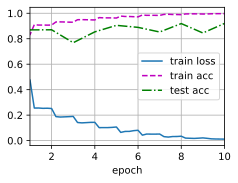

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结
1.学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。  

2.残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。

3.利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。

4.残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。